# Diagnosis of possible issues with EE model

From [this benchmark](https://gaow.github.io/mvarbvs/analysis/20191116_MNM_Benchmark.html) I see some runs with EE model has inflated FDR with no missing data. Here are some digging into it.

In [1]:
%cd ~/GIT/mvarbvs/dsc_mnm

/project2/mstephens/gaow/mvarbvs/dsc_mnm

Here I load previous benchmark results and identify some scenarios where there is a problem,

In [2]:
out = readRDS('../data/finemap_output.20191116.rds')

In [3]:
res = out[,-1]
colnames(res) = c('n_traits', 'resid_method', 'missing', 'EZ_model', 'L', 'total', 'valid', 'size', 'purity', 'top_hit', 'total_true', 'total_true_included', 'overlap_var', 'overlap_cs', 'false_positive_cross_cond', 'false_negative_cross_cond', 'true_positive_cross_cond', 'elbo_converged', 'filename')

In [27]:
bad = res[which(res$total-res$valid>0),]

In [28]:
bad = bad[which(bad$missing==FALSE & bad$EZ_model==0 & bad$n_traits==45 & bad$L<10),]
nrow(bad)

[1] 412

There are quite a few of them with 45 traits. But none seen for $R=5$ or $R=10$. Changing `EZ_model == 1` there is only one such instance as opposed to 412 here.

In [29]:
head(bad)

,n_traits,resid_method,missing,EZ_model,L,total,valid,size,purity,top_hit,total_true,total_true_included,overlap_var,overlap_cs,false_positive_cross_cond,false_negative_cross_cond,true_positive_cross_cond,elbo_converged,filename
6521,45,oracle,FALSE,0,1,1,0,17.0,0.9975257,0,1,0,0,0,45,0,0,TRUE,susie_scores/full_data_21_high_het_2_oracle_generator_1_mnm_high_het_7_susie_scores_1
6913,45,oracle,FALSE,0,1,1,0,37.0,1.0000000,0,1,0,0,0,45,0,0,TRUE,susie_scores/full_data_413_high_het_2_oracle_generator_1_mnm_high_het_7_susie_scores_1
8508,45,oracle,FALSE,0,2,2,1,2.5,0.9960307,1,1,1,0,0,11,34,45,TRUE,susie_scores/full_data_8_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1
8510,45,oracle,FALSE,0,2,2,1,1.5,1.0000000,0,1,1,0,0,0,45,45,TRUE,susie_scores/full_data_10_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1
8511,45,oracle,FALSE,0,2,2,1,24.0,1.0000000,0,1,1,0,0,0,45,45,TRUE,susie_scores/full_data_11_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1
8512,45,oracle,FALSE,0,2,2,1,2.0,1.0000000,0,1,1,0,0,0,45,45,TRUE,susie_scores/full_data_12_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1


Load the 3rd line of dataset identified -- that is, two CS identified but only one of them is valid:

In [30]:
ex = readRDS('mnm_20191116/mnm_high_het/full_data_8_high_het_2_oracle_generator_1_mnm_high_het_9.rds')

In [33]:
DSC_19D98699 <- dscrutils::load_inputs(c('mnm_20191116/oracle_generator/oracle_generator_1.pkl','mnm_20191116/full_data/full_data_8.rds','mnm_20191116/high_het/full_data_8_high_het_2.pkl'), dscrutils::read_dsc)
meta <- DSC_19D98699$meta

The original result from DSC is presented in a plot of PIP and CS, where true signal is in red:

In [9]:
true_pos = as.integer(apply(meta$true_coef, 1, sum) != 0)

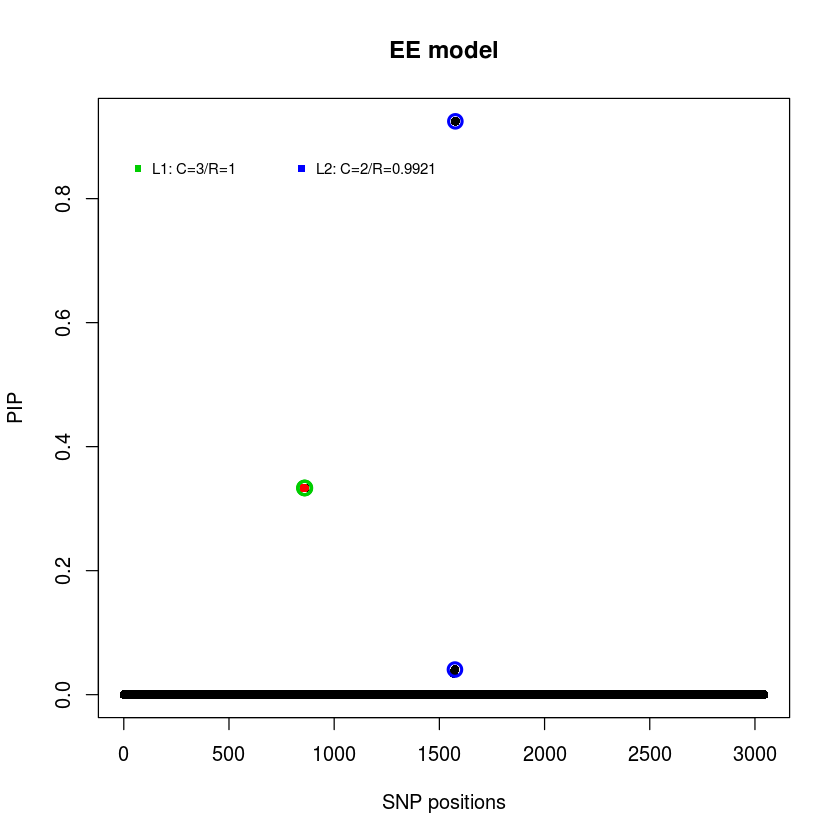

In [36]:
susieR::susie_plot(ex$result,y='PIP', main = 'EE model', xlab = 'SNP positions', add_legend = T, b=true_pos)

## Reproducing the problem with diagnostic information

Starting with analyzing with `L=1`:

In [37]:
DSC_REPLICATE <- DSC_19D98699$DSC_DEBUG$replicate
X <- DSC_19D98699$X
Y <- DSC_19D98699$Y
cfg <- DSC_19D98699$configurations
prior = cfg[[as.character(ncol(Y))]][['high_het']]

In [4]:
compute_cov_diag <- function(Y){
    covar <- diag(apply(Y, 2, var, na.rm=T))
    return(covar)
}

In [5]:
resid_Y <- compute_cov_diag(Y)

In [40]:
#saveRDS(list(X=X,Y=Y,meta=meta,prior=prior,DSC_REPLICATE=DSC_REPLICATE), 'issue_9_EE.rds')

This data-set has also been saved to [here](https://github.com/gaow/mmbr/issues/9#issuecomment-562207003). If you want to reproduce my results you can download the data-set from the link above, use `attach(readRDS(...))` to attach the data to the R workspace and continue with commands below.

Use EE model and set $L=1$,

In [7]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r1 = mmbr::msusie(X, Y, L=1, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F)

To plot and compare results,

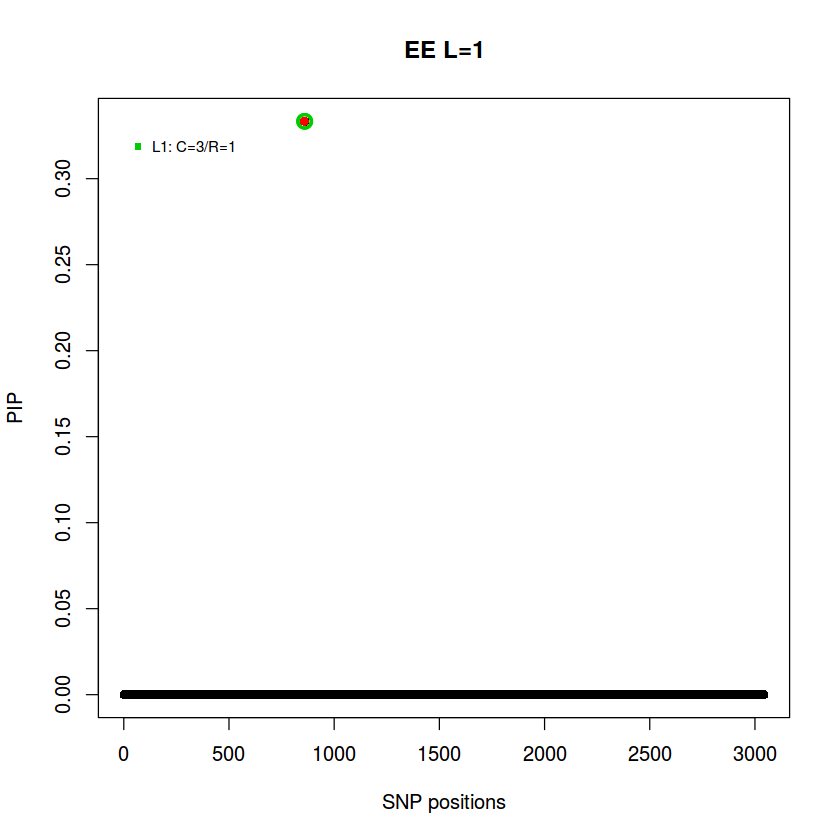

In [10]:
susieR::susie_plot(r1, y='PIP', main = 'EE L=1', xlab = 'SNP positions', add_legend = T, b=true_pos)

So with $L=1$ the first SNP was captured but with low PIP. This is apparently also the top BF. Now try `L=2` to verify the problem:

In [22]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r1 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F)

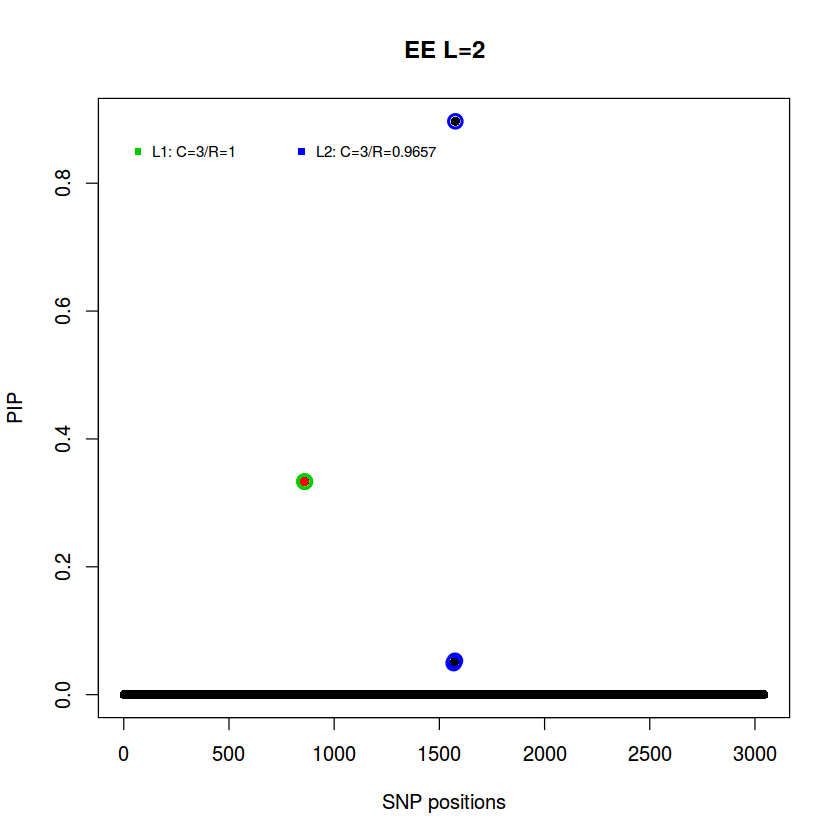

In [12]:
susieR::susie_plot(r1, y='PIP', main = 'EE L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

## Diagnosis using Bayesian multiple regression prior

Here the MASH prior is very simple:

In [14]:
m_init$prior_variance

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


So prior variance is one matrix,

In [15]:
U = m_init$prior_variance$xUlist[[1]]
dim(U)

[1] 45 45

Now fitting it with multivariate Bayesian regression routine not involving MASH. The result should be identical to using MASH EE model in this case:

In [16]:
r2 = mmbr::msusie(X, Y, L=2, prior_variance=U, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F)

It converged fast. The result:

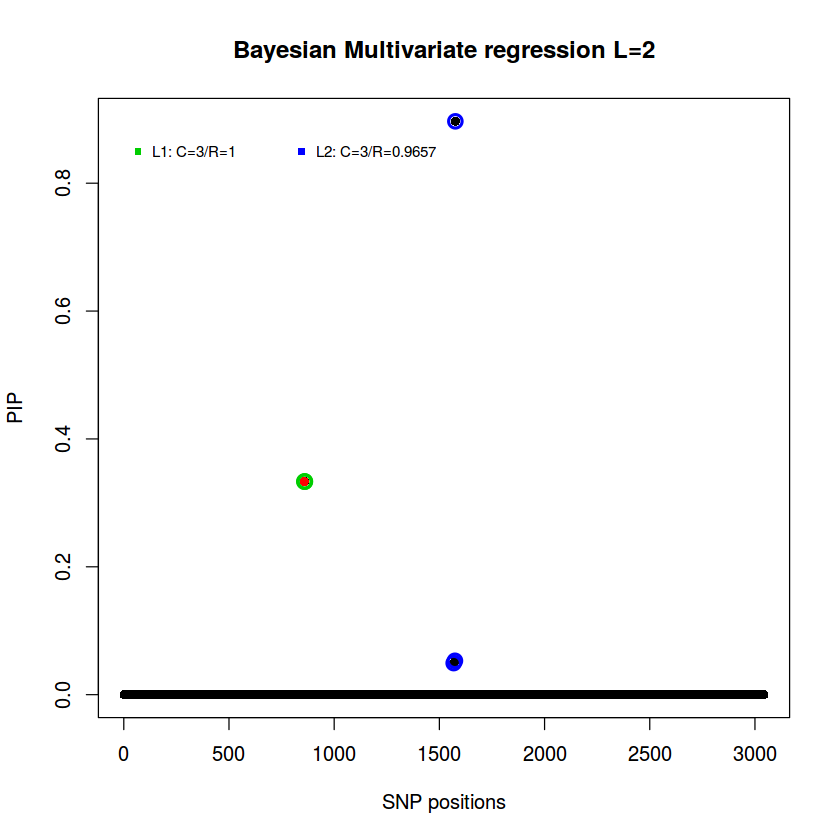

In [17]:
susieR::susie_plot(r1, y='PIP', main = 'Bayesian Multivariate regression L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

Result here is identical and bad! It is not likely that my EE model implementation is wrong at least in this case.

For EE model after center and scale data it should use MASH's `common_cov` computations,

In [26]:
m_init$precompute_cov_matrices(mmbr:::DenseData$new(X,Y),resid_Y)

In [27]:
m_init$precomputed$common_sbhat

[1] TRUE

For data without center and scale,

In [28]:
m_init$precompute_cov_matrices(mmbr:::DenseData$new(X,Y,center=F,scale=F),resid_Y)
m_init$precomputed$common_sbhat

[1] FALSE

And not centering and scaling does change result a bit though not completely (why??):

In [ ]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r1 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, intercept=F, standardize=F)

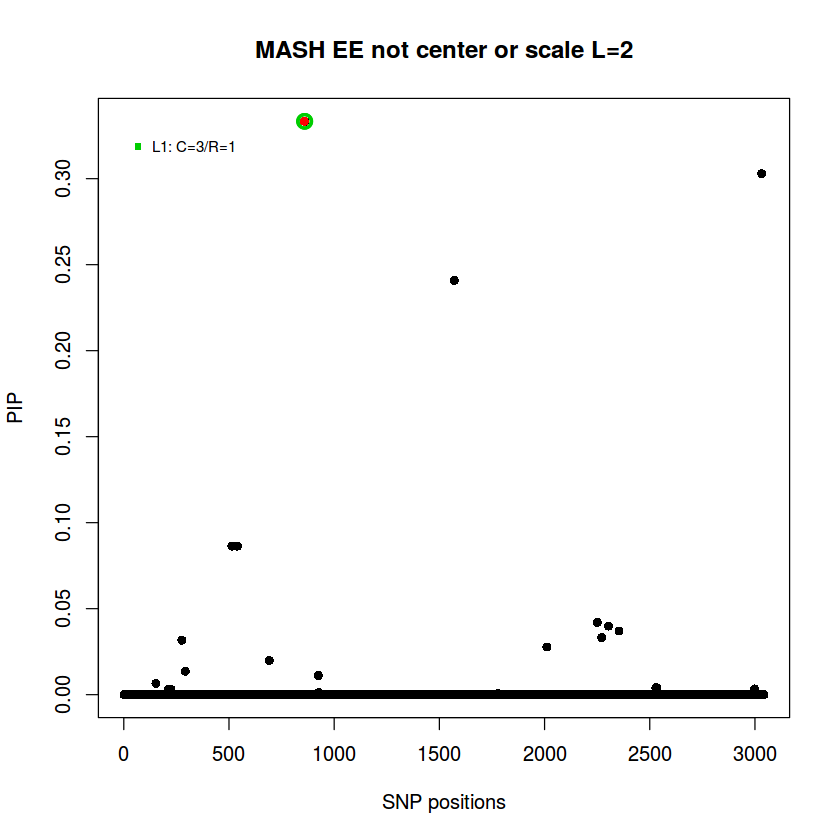

In [31]:
susieR::susie_plot(r1, y='PIP', main = 'MASH EE not center or scale L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

In [35]:
r1 = mmbr::msusie(X, Y, L=2, prior_variance=U, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, intercept=F, standardize=F)

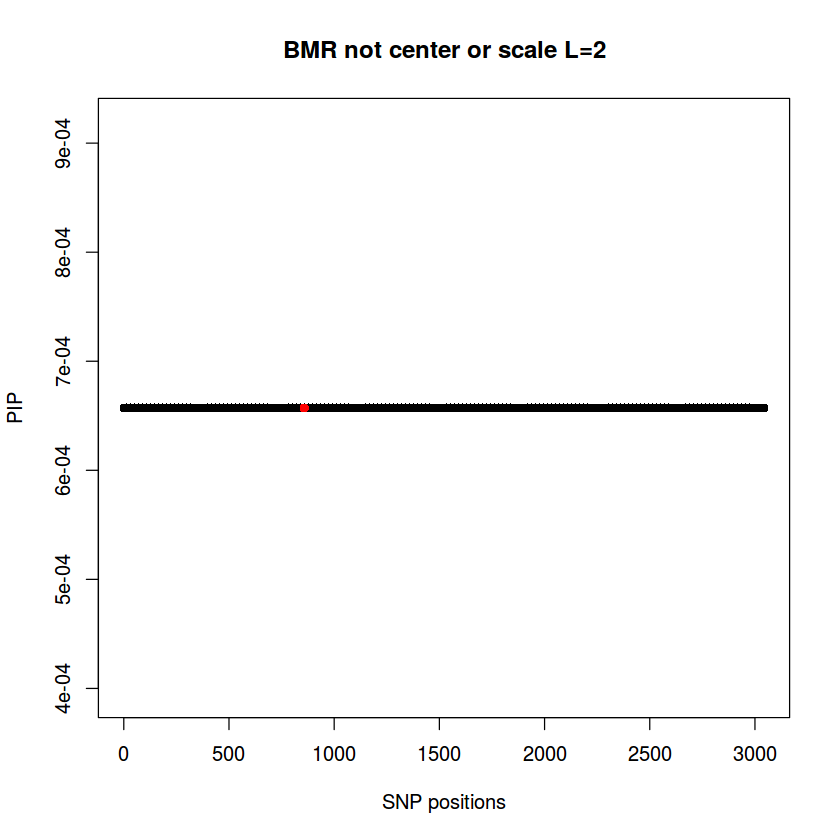

In [36]:
susieR::susie_plot(r1, y='PIP', main = 'BMR not center or scale L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

Using EZ model, however, seems to work.

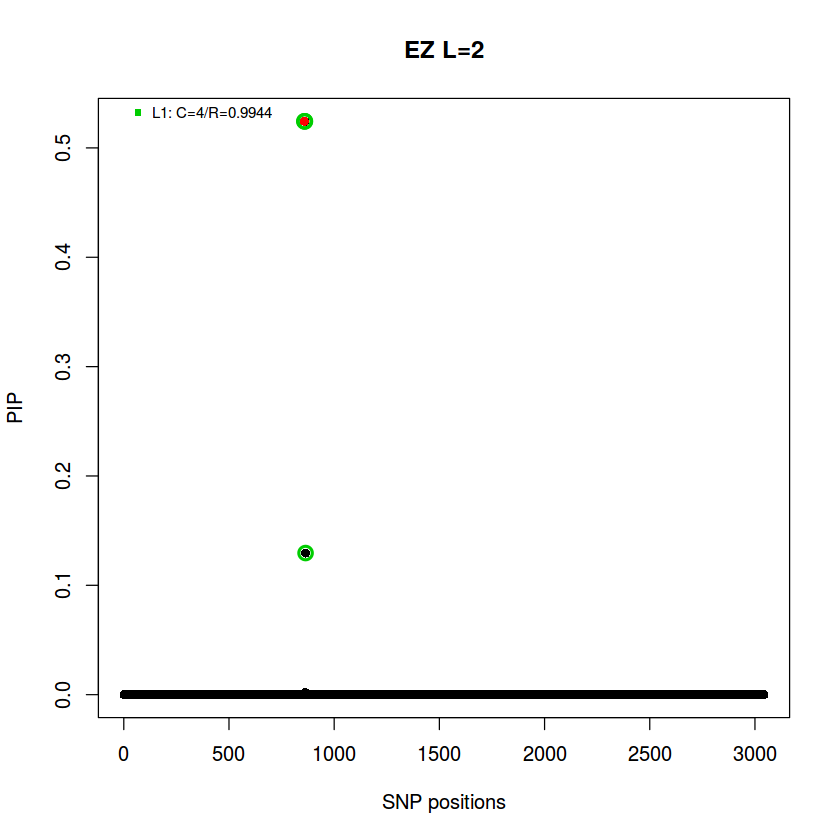

In [20]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=1, top_mixtures=-1)
r3 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F)
susieR::susie_plot(r3, y='PIP', main = 'EZ L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

In [ ]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
